# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

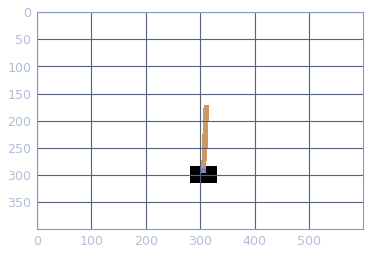

In [2]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, 'env'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [3]:
class PolicyApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(16, activation='relu', name='dense1')
        self.d2 = Dense(32, activation='relu', name='dense2')
        self.d3 = Dense(32, activation='relu', name='dense3')
        self.d4 = Dense(16, activation='relu', name='dense4')
        self.d5 = Dense(2, activation=None)

    def call(self, x):
        x = tf.expand_dims(x, 0)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return self.d5(x)

In [4]:
def policy(states):
    return tf.nn.softmax(policy_approximator(states))

def log_policy(states):
    return tf.nn.log_softmax(policy_approximator(states))

def get_action_probs(states):
    log_action_probs = tf.squeeze(log_policy(states), 0)
    action_probs = tf.squeeze(policy(states), 0)
    return log_action_probs, action_probs

def get_cumulative_rewards(rewards,  gamma=0.99):
    cumulative_returns = np.zeros(len(rewards))
    G = 0
    for i in range(len(rewards) - 1, -1, -1):
        G = gamma * G + rewards[i]
        cumulative_returns[i] = G
    return cumulative_returns

def compute_objective(log_action_probs, actions, cumulative_returns):
    log_action_taken_probs = tf.gather_nd(log_action_probs, tf.stack([tf.range(log_action_probs.shape[0]), actions], axis=1))
    J = tf.math.reduce_mean(tf.math.multiply(log_action_taken_probs, cumulative_returns))
    return J

def compute_entropy(action_probs, log_action_probs):
    return - tf.math.reduce_sum(tf.math.multiply(action_probs, log_action_probs))


#def compute_loss(cache_action_probs, cache_log_action_probs, cumulative_returns, entropy_coef):
#    return - compute_objective(cache_log_action_probs, cumulative_returns) - entropy_coef * entropy(cache_action_probs, cache_log_action_probs)



### Playing the game

In [5]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions and rewards
    """

    # arrays to record session
    states, actions, rewards, cache_action_probs, cache_log_action_probs = np.asarray([], dtype='float32'), [], [], np.asarray([], dtype='float32'),  np.asarray([], dtype='float32')

    s = env.reset().astype('float32')

    for t in range(t_max):

        # action probabilities and log probabilities
        log_action_probs, action_probs = get_action_probs(s)
        log_action_probs = log_action_probs.numpy().reshape(2,)
        action_probs = action_probs.numpy().reshape(2,)
        # choose an action
        action_t = np.random.choice([0, 1], p=action_probs)
        # perform a step
        new_s, r, done, info = env.step(action_t)
      #  print(action_probs, action_t)

        # record session history to train later
        states = np.concatenate((states, s), axis=0)
        cache_action_probs = np.concatenate((cache_action_probs, action_probs), axis=0)
        cache_log_action_probs = np.concatenate((cache_log_action_probs, log_action_probs), axis=0)
        actions.append(action_t)
        rewards.append(r)

        s = new_s.astype('float32')
        if done:
            break
            
    return states.reshape(-1, s.shape[0]), actions, rewards, cache_action_probs.reshape(-1, env.action_space.n), cache_log_action_probs.reshape(-1, env.action_space.n)

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [10]:
# Create an instance of the model
policy_approximator = PolicyApproximator(action_dim=env.action_space.n)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [11]:
def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    # Gradient descent step
    with tf.GradientTape() as tape:
        # cast everything into tensorflow tensors
        states = tf.Variable(states, dtype='float32', name='states')
        actions = tf.Variable(actions, dtype='int32', name='actions')
        cumulative_returns = get_cumulative_rewards(rewards, gamma)
        cumulative_returns = tf.Variable(cumulative_returns, dtype='float32', name='cumulative_returns')
        
        # Compute action probs
        log_action_probs, action_probs = get_action_probs(states)
        
        # Compute entropy
        entropy = compute_entropy(log_action_probs, action_probs)
        
        # Compute objective
        #import pdb; pdb.set_trace()
        J = compute_objective(log_action_probs, actions, cumulative_returns)
        loss = -J + entropy_coef * entropy
        
       # print(policy_approximator.trainable_variables)
    
    gradients = tape.gradient(loss, policy_approximator.trainable_variables, )
    optimizer.apply_gradients(zip(gradients, policy_approximator.trainable_variables))        

    # technical: return session rewards to print them later
    return np.sum(rewards)

In [12]:
global_rewards = []

for i in range(10000):

    rewards = train_on_session(*generate_session()[0:3]) # generate new sessions
    global_rewards.append(rewards)
    
    if i % 100 == 0:
        print(np.mean(global_rewards[-100:]))

    if np.mean(global_rewards[-100:]) > 300:
        print("You Win!")
        break

18.0
28.14
34.3
35.01
60.87
108.74
42.46
226.21
You Win!


### Results & video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices